In [4]:
pip install mysql-connector-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.1/15.1 MB 779.4 kB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


In [5]:
import pandas as pd
import mysql.connector
import os

# List of CSV files and their corresponding table names
csv_files = [
    ('customers.csv', 'customers'),
    ('orders.csv', 'orders'),
    ('sellers.csv', 'sellers'),
    ('products.csv', 'products'),
    ('geolocation.csv', 'geolocation'),
    ('payments.csv', 'payments'),
    ('order_items.csv', 'order_items') # Added payments.csv for specific handling
]

# Connect to the MySQL database
conn = mysql.connector.connect(
    host='localhost',
    user='root',
    password='workhard12!@',
    database='ecommerce'
)
cursor = conn.cursor()

# Folder containing the CSV files
folder_path = '/Users/kartikpatidar/Downloads/Work/SQL projects/Target_project'

def get_sql_type(dtype):
    if pd.api.types.is_integer_dtype(dtype):
        return 'INT'
    elif pd.api.types.is_float_dtype(dtype):
        return 'FLOAT'
    elif pd.api.types.is_bool_dtype(dtype):
        return 'BOOLEAN'
    elif pd.api.types.is_datetime64_any_dtype(dtype):
        return 'DATETIME'
    else:
        return 'TEXT'

for csv_file, table_name in csv_files:
    file_path = os.path.join(folder_path, csv_file)
    
    # Read the CSV file into a pandas DataFrame
    df = pd.read_csv(file_path)
    
    # Replace NaN with None to handle SQL NULL
    df = df.where(pd.notnull(df), None)
    
    # Debugging: Check for NaN values
    print(f"Processing {csv_file}")
    print(f"NaN values before replacement:\n{df.isnull().sum()}\n")

    # Clean column names
    df.columns = [col.replace(' ', '_').replace('-', '_').replace('.', '_') for col in df.columns]

    # Generate the CREATE TABLE statement with appropriate data types
    columns = ', '.join([f'`{col}` {get_sql_type(df[col].dtype)}' for col in df.columns])
    create_table_query = f'CREATE TABLE IF NOT EXISTS `{table_name}` ({columns})'
    cursor.execute(create_table_query)

    # Insert DataFrame data into the MySQL table
    for _, row in df.iterrows():
        # Convert row to tuple and handle NaN/None explicitly
        values = tuple(None if pd.isna(x) else x for x in row)
        sql = f"INSERT INTO `{table_name}` ({', '.join(['`' + col + '`' for col in df.columns])}) VALUES ({', '.join(['%s'] * len(row))})"
        cursor.execute(sql, values)

    # Commit the transaction for the current CSV file
    conn.commit()

# Close the connection
conn.close()

Processing customers.csv
NaN values before replacement:
customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

Processing orders.csv
NaN values before replacement:
order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

Processing sellers.csv
NaN values before replacement:
seller_id                 0
seller_zip_code_prefix    0
seller_city               0
seller_state              0
dtype: int64

Processing products.csv
NaN values before replacement:
product_id                      0
product category              610
product_name_length           610
product_description_length    610
product_photos_qty            610
prod

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector
import numpy as np

db = mysql.connector.connect(
    host='localhost',
    user='root',
    password='workhard12!@',
    database='ecommerce'
)

cur = db.cursor()



# List all unique cities where customers are located.

In [34]:
query = """ select distinct customer_city from customers """
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data)
df.head()

,0
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas


# Count the number of orders placed in 2017.

In [9]:
query = """ select count(order_id)
from orders 
where year(order_purchase_timestamp) = 2017; """
cur.execute(query)
data = cur.fetchall()
"total number 0f orders in 2017 are:",data[0][0]

('total number 0f orders in 2017 are:', 45101)

# Find the total sales per category.

In [16]:
query = """ select upper(pr.product_category),round(sum(py.payment_value),2) asssales
from (order_items as oi join products as pr
on oi.product_id = pr.product_id
join payments as py 
on py.order_id = oi.order_id)
group by pr.product_category
; """
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns = ["category","sales"])
df

,category,sales
0,PERFUMERY,506738.66
1,FURNITURE DECORATION,1430176.39
2,TELEPHONY,486882.05
3,BED TABLE BATH,1712553.67
4,AUTOMOTIVE,852294.33
...,...,...
69,CDS MUSIC DVDS,1199.43
70,LA CUISINE,2913.53
71,FASHION CHILDREN'S CLOTHING,785.67
72,PC GAMER,2174.43


# Calculate the percentage of orders that were paid in installments.

In [24]:
query = """ select(count(order_id)/ (select count(order_id) 
from payments))*100
from payments 
where payment_installments >=1; """
cur.execute(query)
data = cur.fetchall()
data

[(Decimal('99.9981'),)]

# Count the number of customers from each state. 

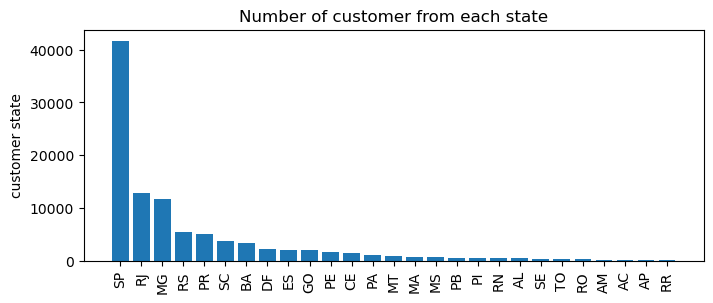

In [33]:
query = """ select customer_state,count(customer_id) as customer
from customers
group by customer_state
order by customer desc;
 """
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns = ["customer_state","customer"])
plt.figure(figsize = (8,3))
plt.bar(df.customer_state,df.customer)
plt.title('Number of customer from each state')
plt.ylabel('customer state')

plt.xticks(rotation=90)
plt.show()

# Calculate the number of orders per month in 2018.

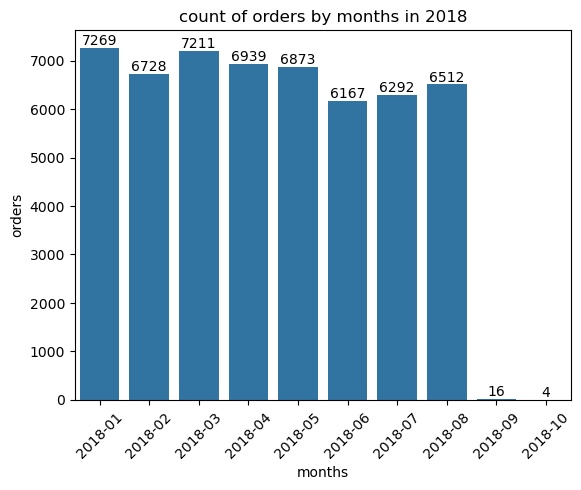

In [56]:
query = """ SELECT 
    DATE_FORMAT(order_purchase_timestamp, '%Y-%m') AS order_month,
    COUNT(order_id) AS number_of_orders
FROM 
    orders
WHERE 
    YEAR(order_purchase_timestamp) = 2018
GROUP BY 
    order_month
ORDER BY 
    order_month;"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns = ["months","orders"])

ax = sns.barplot(x=df.months,y=df.orders)
plt.xticks(rotation = 45)
plt.title('count of orders by months in 2018')
ax.bar_label(ax.containers[0])


plt.show()

# Find the average number of products per order, grouped by customer city.

In [5]:
query = """select cu.customer_city,round((count(oi.order_item_id)/count(distinct o.order_id)),2) as products_per_order
from customers as cu join orders as o
on cu.customer_id = o.customer_id
join order_items as oi 
on oi.order_id = o.order_id
group by cu.customer_city;"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data , columns=["customer city","average orders"])
df.head(10)

,customer city,average orders
0,abadia dos dourados,1.00
1,abadiania,1.00
2,abaete,1.00
3,abaetetuba,1.27
4,abaiara,1.00
5,abaira,1.00
6,abare,1.00
7,abatia,1.00
8,abdon batista,2.00
9,abelardo luz,1.00


# Calculate the percentage of total revenue contributed by each product category.

In [7]:
query = """select pr.product_category,round((sum(p.payment_value)/(select sum(payment_value)
from payments))*100,2)as sales
from order_items as oi join products as pr
on oi.product_id = pr.product_id
join payments as p
on p.order_id = oi.order_id
group by pr.product_category
order by sales desc;"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data , columns=["Product Cateegory","Sales %"])
df.head(10)

,Product Cateegory,Sales %
0,bed table bath,10.70
1,HEALTH BEAUTY,10.35
2,computer accessories,9.90
3,Furniture Decoration,8.93
4,Watches present,8.93
5,sport leisure,8.70
6,housewares,6.84
7,automotive,5.32
8,Garden tools,5.24
9,Cool Stuff,4.87


# Identify the correlation between product price and the number of times a product has been purchased.

In [15]:
query = """select pr.product_category,count(oi.product_id),round(avg(oi.price),2)
from products as pr join order_items as oi
on pr.product_id = oi.product_id
group by pr.product_category;"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns = ["category","order count","price"])

arr1 = df["order count"]
arr2 = df["price"]
a = np.corrcoef([arr1,arr2])
print("The correlation is",a[0][1])

The correlation is -0.10631514167157562


#  Calculate the total revenue generated by each seller and rank them by revenue.

In [14]:
query = """ select *, dense_rank() over(order by revenue desc) as rn 
 from
 (select oi.seller_id, round(sum(py.payment_value),2) as revenue
from order_items as oi join payments as py
on oi.order_id = py.order_id
group by oi.seller_id) as a;"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data , columns=["seller id","revenue","rank"])
df.head(10)

,seller id,revenue,rank
0,7c67e1448b00f6e969d365cea6b010ab,507166.91,1
1,1025f0e2d44d7041d6cf58b6550e0bfa,308222.04,2
2,4a3ca9315b744ce9f8e9374361493884,301245.27,3
3,1f50f920176fa81dab994f9023523100,290253.42,4
4,53243585a1d6dc2643021fd1853d8905,284903.08,5
5,da8622b14eb17ae2831f4ac5b9dab84a,272219.32,6
6,4869f7a5dfa277a7dca6462dcf3b52b2,264166.12,7
7,955fee9216a65b617aa5c0531780ce60,236322.30,8
8,fa1c13f2614d7b5c4749cbc52fecda94,206513.23,9
9,7e93a43ef30c4f03f38b393420bc753a,185134.21,10


# Calculate the moving average of order values for each customer over their order history.

In [18]:
query = """select customer_id,order_purchase_timestamp,
avg(payment) over(partition by customer_id order by order_purchase_timestamp
rows between 2 preceding and current row)
from
(select o.customer_id,o.order_purchase_timestamp,py.payment_value as payment 
from orders as o join payments as py
on o.order_id = py.order_id) as a"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data , columns=["Customr id","order date","moving average of 3 orders"])
df.head(10)

,Customr id,order date,moving average of 3 orders
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.739998
1,000161a058600d5901f007fab4c27140,2017-07-16 09:40:32,67.410004
2,0001fd6190edaaf884bcaf3d49edf079,2017-02-28 11:06:43,195.419998
3,0002414f95344307404f0ace7a26f1d5,2017-08-16 13:09:20,179.350006
4,000379cdec625522490c315e70c7a9fb,2018-04-02 13:42:17,107.010002
5,0004164d20a9e969af783496f3408652,2017-04-12 08:35:12,71.800003
6,000419c5494106c306a97b5635748086,2018-03-02 17:47:40,49.400002
7,00046a560d407e99b969756e0b10f282,2017-12-18 11:08:30,166.589996
8,00050bf6e01e69d5c0fd612f1bcfb69c,2017-09-17 16:04:44,85.230003
9,000598caf2ef4117407665ac33275130,2018-08-11 12:14:35,1255.709961


# Calculate the cumulative sales per month for each year.

In [6]:
query = """select years,months,round(sum(payments)
over(order by years,months),2) as cumulative_sales
from
(select year(o.order_purchase_timestamp) as years,
month(o.order_purchase_timestamp) as months,
sum(py.payment_value) as payments
from orders as o join payments as py
on o.order_id = py.order_id
group by years,months
order by years,months) as a; """
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data , columns=["years","months","cumulative sales"])
df


,years,months,cumulative sales
0,2016,9,252.24
1,2016,10,59342.72
2,2016,12,59362.34
3,2017,1,197850.38
4,2017,2,489758.39
5,2017,3,939621.99
6,2017,4,1357410.02
7,2017,5,1950328.84
8,2017,6,2461605.22
9,2017,7,3053988.14


# Calculate the year-over-year growth rate of total sales.

In [8]:
query = """with a as(select year(o.order_purchase_timestamp) as years,
round(sum(py.payment_value),2) as payments
from orders as o join payments as py
on o.order_id = py.order_id
group by years
order by years)
select years,round(((payments - lag(payments,1) over(order by years))
/lag(payments,1) over(order by years))*100,2) from a;"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data , columns=["years","yoy % growth"])
df


,years,yoy % growth
0,2016,NaN
1,2017,12112.7
2,2018,20.0


# Calculate the retention rate of customers, defined as the percentage of customers who make another purchase within 6 months of their first purchase.

In [10]:
query = """WITH FirstPurchase AS (
SELECT 
        customer_id,
        MIN(order_purchase_timestamp) AS first_purchase_date
    FROM 
        orders
    GROUP BY 
        customer_id
),
SubsequentPurchases AS (
    SELECT 
        fp.customer_id,
        fp.first_purchase_date,
        MIN(sd.order_purchase_timestamp) AS next_purchase_date
    FROM 
        FirstPurchase fp
    JOIN 
        orders sd
    ON 
        fp.customer_id = sd.customer_id
        AND sd.order_purchase_timestamp > fp.first_purchase_date
    GROUP BY 
        fp.customer_id, fp.first_purchase_date
),
RetainedCustomers AS (
    SELECT 
        customer_id,
        CASE 
            WHEN DATEDIFF(next_purchase_date, first_purchase_date) <= 180 THEN 1
            ELSE 0
        END AS is_retained
    FROM 
        SubsequentPurchases
)
SELECT 
    ROUND((SUM(is_retained) * 100.0 / COUNT(*)), 2) AS retention_rate
FROM 
    RetainedCustomers;"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data , columns=["customer retention rate"])
df

,customer retention rate
0,None


# Identify the top 3 customers who spent the most money in each year.

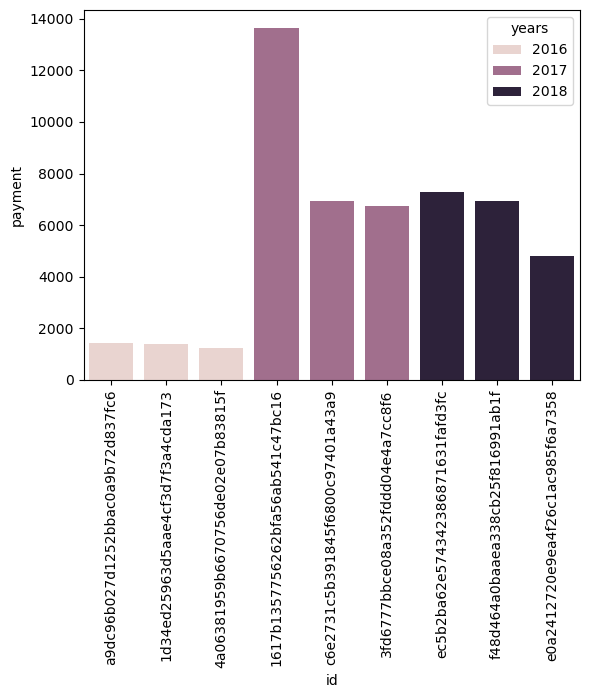

In [47]:
query = """select years,customer_id,money_spent,d_rnk
from
(select year(o.order_purchase_timestamp)as years,
o.customer_id as customer_id,
round(sum(py.payment_value),2) as money_spent,
dense_rank() over(partition by year(o.order_purchase_timestamp) order by sum(py.payment_value) desc) as d_rnk
from orders as o join payments as py
on o.order_id = py.order_id
group by o.order_purchase_timestamp,o.customer_id)as a
where d_rnk <=3;"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data , columns=["years","id","payment","rank"])

ax = sns.barplot(x="id", y= "payment" ,data=df, hue="years")
plt.xticks(rotation = 90)
plt.show()